
Tuning: Random Forest
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best Params for Random Forest: {'classifier__n_estimators': 100, 'classifier__min_samples_split': 5, 'classifier__min_samples_leaf': 2, 'classifier__max_depth': None, 'classifier__bootstrap': True}

Tuning: Logistic Regression
Fitting 3 folds for each of 8 candidates, totalling 24 fits
Best Params for Logistic Regression: {'classifier__solver': 'liblinear', 'classifier__penalty': 'l2', 'classifier__C': 1.0}


C:\Users\shyam\AppData\Local\anaconda3\Lib\site-packages\sklearn\model_selection\_search.py:320: UserWarning: The total space of parameters 8 is smaller than n_iter=10. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


AUC Score for Random Forest: 0.779
AUC Score for Logistic Regression: 0.884


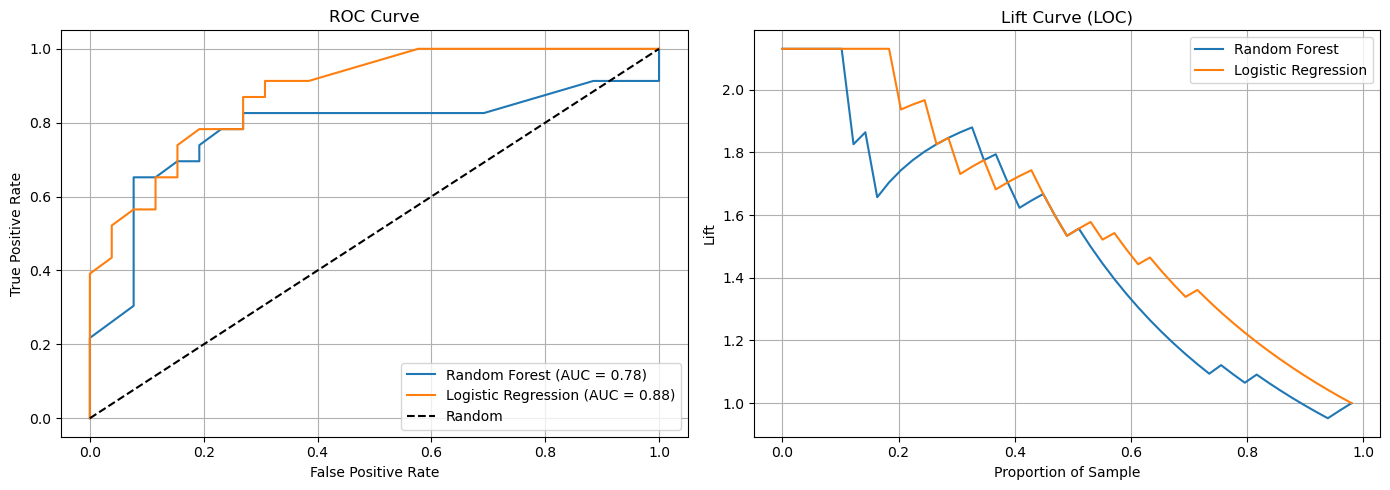

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve

# Load dataset
df = sns.load_dataset("tips")

# Binary classification target
y = df["total_bill"] > df["total_bill"].median()
X = df.drop("total_bill", axis=1)

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Identify column types
categorical_cols = X.select_dtypes(include="object").columns
numerical_cols = X.select_dtypes(include=["int64", "float64"]).columns

# Preprocessor
preprocessor = ColumnTransformer([
    ("num", Pipeline([
        ("imputer", SimpleImputer(strategy="mean")),
        ("scaler", StandardScaler())
    ]), numerical_cols),

    ("cat", Pipeline([
        ("imputer", SimpleImputer(strategy="constant", fill_value="missing")),
        ("encoder", OneHotEncoder(handle_unknown="ignore"))
    ]), categorical_cols)
])

# Define models and search space
randomcv_models = [
    ("Random Forest", Pipeline([
        ("preprocessor", preprocessor),
        ("classifier", RandomForestClassifier(random_state=42))
    ]), {
        "classifier__n_estimators": [50, 100, 200],
        "classifier__max_depth": [None, 10, 20],
        "classifier__min_samples_split": [2, 5],
        "classifier__min_samples_leaf": [1, 2],
        "classifier__bootstrap": [True, False]
    }),

    ("Logistic Regression", Pipeline([
        ("preprocessor", preprocessor),
        ("classifier", LogisticRegression(max_iter=200, random_state=42))
    ]), {
        "classifier__penalty": ["l2"],
        "classifier__C": [0.01, 0.1, 1.0, 10],
        "classifier__solver": ["liblinear", "lbfgs"]
    })
]

# Hyperparameter tuning
model_param = {}

for name, model, params in randomcv_models:
    print(f"\nTuning: {name}")
    random = RandomizedSearchCV(
        estimator=model,
        param_distributions=params,
        n_iter=10,
        cv=3,
        n_jobs=-1,
        verbose=1,
        random_state=42
    )
    random.fit(X_train, y_train)
    model_param[name] = random.best_params_
    print(f"Best Params for {name}: {random.best_params_}")

# Lift Curve function
def plot_lift_curve(y_true, y_proba, model_name):
    df_lift = pd.DataFrame({"y_true": y_true, "y_score": y_proba})
    df_lift = df_lift.sort_values("y_score", ascending=False).reset_index(drop=True)
    df_lift["cum_response"] = df_lift["y_true"].cumsum()
    df_lift["lift"] = df_lift["cum_response"] / (np.arange(1, len(df_lift) + 1))
    baseline = df_lift["y_true"].sum() / len(df_lift)
    lift = df_lift["lift"] / baseline
    plt.plot(np.arange(len(df_lift)) / len(df_lift), lift, label=model_name)
    plt.xlabel("Proportion of Sample")
    plt.ylabel("Lift")
    plt.title("Lift Curve (LOC)")
    plt.grid(True)

# ROC & LOC evaluation
def evaluate_models_roc_loc(models, model_param, X_train, y_train, X_test, y_test):
    plt.figure(figsize=(14, 5))

    # ROC
    plt.subplot(1, 2, 1)
    for name, model, _ in models:
        best_model = model.set_params(**model_param[name])
        best_model.fit(X_train, y_train)
        y_proba = best_model.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        auc = roc_auc_score(y_test, y_proba)
        plt.plot(fpr, tpr, label=f"{name} (AUC = {auc:.2f})")
        print(f"AUC Score for {name}: {auc:.3f}")
    plt.plot([0, 1], [0, 1], 'k--', label='Random')
    plt.title("ROC Curve")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.grid(True)

    # LOC
    plt.subplot(1, 2, 2)
    for name, model, _ in models:
        best_model = model.set_params(**model_param[name])
        best_model.fit(X_train, y_train)
        y_proba = best_model.predict_proba(X_test)[:, 1]
        plot_lift_curve(y_test, y_proba, model_name=name)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Evaluate and plot
evaluate_models_roc_loc(randomcv_models, model_param, X_train, y_train, X_test, y_test)
